> [Amanda L Richer, Kent A Riemondy, Lakotah Hardie, Jay R Hesselberth, **Simultaneous measurement of biochemical phenotypes and gene expression in single cells**, *Nucleic Acids Research*, (2020)](https://doi.org/10.1093/nar/gkaa240)

> **Dataset:** Cell line models targeted with CRISPR technology and UNG<sup>KO</sup> and RNASEH2C<sup>KO</sup> used for single cell RNA experssion experiments (haicut-seq) in 3 timepoints. 
> - **Cell line:** Hap1 UNG<sup>KO</sup> (HZGHC001531c012) and RNASEH2C<sup>KO</sup> (HZGHC004633c003) cells.


**Aim:** Build context specific networks from pySCENIC results and connect with public datasetset such as PPI netwrok or CanDI

**Toolboxs:** 
- [python-igraph](https://igraph.org/python/) – The network analysis package
<!-- igraph is a collection of network analysis tools with the emphasis on efficiency, portability and ease of use. igraph is open source and free. -->


- [stringdb](https://pypi.org/project/stringdb/) - Python functions to access the STRINGdb API, a source of protein-protein association networks.

<!-- https://stackoverflow.com/questions/44400345/create-igraph-graph-from-pandas-dataframe

https://briatte.github.io/ggnet/

https://igraph.org/python/doc/tutorial/visualisation.html

https://stackoverflow.com/questions/66008439/how-to-plot-an-igraph-object-on-matplotlib-axes -->

- [pySCENIC](https://pyscenic.readthedocs.io/) - python implementation of the SCENIC pipeline (Single-Cell rEgulatory Network Inference and Clustering)

- [CanDI](https://candi.readthedocs.io/) - 

# Conclusion
1. I've tried different ways to candidate altered TF activity over time. It's shown that [DDIT3](#DDIT3) and [SIX2](#SIX2) in our dataset show larger number of cells that have active TF after 60' treatment with DNA-Damage hairpins. 
2. Cells grouped as low and high repair phenotype didn't show different pattern for altered TFs. 

In [2]:
import os
import sys
from glob import glob
import pandas as pd
import numpy as np

import scanpy as sc
import anndata as ann
import matplotlib.pyplot as plt 
from matplotlib.gridspec import SubplotSpec
import stringdb
import igraph as ig
import networkx as nx
# import algorithmx
from pyscenic.plotting import plot_binarization
from pyscenic.rss import regulon_specificity_scores

sys.path.append('../ipage-down/')

import ipage_down as ipd

import utils
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
start = "\033[1m"
end = "\033[0;0m"

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.5.3 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [3]:
!python --version

Python 3.6.13 :: Anaconda, Inc.


__Make `igraph` objects__

In [4]:
def get_graph_features(g,out=None):
    print (g.summary(),'\n')
    print("Number of vertices in the graph:", g.vcount())
    print("Number of edges in the graph", g.ecount())
    print("Is the graph directed:", g.is_directed())
    print("Maximum degree in the graph:", g.maxdegree())
    
    top_nodes = g.vs.select(_degree = g.maxdegree())["name"]
    print("Node name with Maximum degree:",top_nodes)
    if out is 'maxdegree':
        return top_nodes
    if out is 'adjmtx':    
        # Adjacency matrix
        adj = g.get_adjacency()
        adj_df = pd.DataFrame(adj,index=g.vs['name'],columns=g.vs['name'])
        return adj_df

In [5]:
def nodes2df(G):
    node_df = pd.DataFrame({attr: G.vs[attr] for attr in G.vertex_attributes()})
    return node_df

Sama's suggestion:
https://algorithmx-python.readthedocs.io/en/latest/examples/networkx-examples.html

__Depth First Search__

https://stackoverflow.com/questions/29783828/convert-python-igraph-graph-to-networkx

https://networkx.org/documentation/stable/reference/algorithms/traversal.html#module-networkx.algorithms.traversal.breadth_first_search

https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/

In [6]:
def node_i(graph,node):
    return [i for i,x in enumerate(graph.vs['name']) if x == node][0]


def run_bfs(graph,node,distance=1):

    A = [edge.tuple for edge in graph.es]
    # if directed:
    #     # In case your graph is directed
    #     G = nx.DiGraph(A)
    # else:
    #     # In case you graph is undirected
    G = nx.Graph(A)
    # bfs = nx.edge_bfs(G,node)
    bfs = nx.descendants_at_distance(G, source=node_i(graph,node), distance=distance)
    
    out = [graph.vs['name'][i] for i in list(bfs)]
    return out

__Filter graphs__

In [7]:
def filter_graph_by_targets(inG,targets,max_distance=2, weight_thr=None,verbose=True):
    """filter adjacencies matrix by running BFS for given targets 
    """
    # filter adjacencies by given target genes 
    if type(targets) is str:
        targets = [targets]
    adj = adjacencies[adjacencies['target'].isin(targets)]

    bfs = []
    for gene in targets:
        for distance in range(1,max_distance+1):
            bfs = bfs + run_bfs(inG,gene,distance=distance)
    
    outG = inG.vs.select(name_in=bfs + targets).subgraph()
    
    # subset graph by weight threshold 
    if weight_thr: 
        outG = outG.es.select([i for i,x in enumerate (outG.es['weight']) if x >= weight_thr]).subgraph()
    if verbose: get_graph_features(outG)
    
    return outG


def filter_graph_by_regulon(inG,regulons,weight_thr=None):
    """filter adjacencies matrix by running BFS for given regulon 
    """
    # filter adjacencies by given target genes 
    if type(regulons) is str:
        regulons = [regulons]
    adj = adjacencies[adjacencies['TF'].isin(regulons)]
    adj = adj[
        # finding genes with a distance from given nodes
        np.array([
            adj['target'].isin(run_bfs(inG,reg,distance=1) + regulons) for reg in regulons
        ]).any(axis=0)
    ]
    
    # create igraph from dataframe
    outG = ig.Graph.TupleList(
        adj.itertuples(index=False),
        directed=True, weights=True
    )
    # subset graph by weight threshold 
    if weight_thr: 
        outG = outG.es.select([i for i,x in enumerate (outG.es['weight']) if x >= weight_thr]).subgraph()
    
    return outG

__plot graph__

___


[Visualising Graph Data with Python-igraph](https://towardsdatascience.com/visualising-graph-data-with-python-igraph-b3cc81a495cf)

[Newbies Guide to Python-igraph
](https://towardsdatascience.com/newbies-guide-to-python-igraph-4e51689c35b4m)
<!-- > I have used python-graph in my latest published tool [GraphBin](https://github.com/Vini2/GraphBin). In this article, I will introduce you to some basic functions of python-igraph which can make implementation much easier with just a single call.
> In this article, we will go through the functions that perform the following tasks.
> 1. Creating a graph
> 1. Visualising the graph
> 1. Obtaining information on the vertices and edges of the graph
> 1. Obtaining adjacent vertices to a vertex
> 1. Breadth-first search (BFS) from a vertex
> 1. Determining shortest paths from a vertex
> 1. Obtain the Laplacian matrix of a graph
> 1. Determine the maximum flow between the source and target vertices -->

In [8]:
def plot_graph(G,layout="kk",main_node=None,target=None,b1=350,b2=350):
    G.vs["color"] = [
        "lightblue" if (vertex['name'] in [x.replace('(+)','') for x in auc_mtx.columns.to_list()])
        else "lightgray" for vertex in G.vs
    ]
    
    if main_node in G.vs['name']: 
        G.vs[[i for i,x in enumerate (G.vs['name']) if x == main_node][0]]['color'] = 'yellow'

    return ig.plot(
        G,
        layout=G.layout(layout),
        vertex_label=G.vs["name"],
        vertex_color=G.vs["color"],
        vertex_label_size=6,vertex_size=35,
        bbox = (b1, b2), margin = 20,
#         target=target
    )


__mRNA Expression dotplot__

In [9]:
def splited_dot_plot(adata,genes1,name1,genes2,name2,save=None):
    rows = 2
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(15,30), gridspec_kw={'hspace':1,'wspace':0.3})


    for i,adata in enumerate([mix15,mix30,mix60]):

        times = ['15','30','60'] 
        damages = ['dU','rG'] 
        repairs = ['Uracil-repair', 'riboG-repair']

        signal = list()

        for j in range(2):

            genes_dict = {
                name1: genes1,#list(set(genes1).intersection(up+dn)),
                name2: genes2 #list(set(genes2).intersection(up+dn))
            }

            ax_dict = sc.pl.dotplot(
                adata[adata.obs[repairs[j]] != 'none',],
                genes_dict,
                title=f'{times[i]}\' Treatment experiment',
    #             dot_max=0.5, dot_min=0.3, 
                standard_scale='var',
                swap_axes=True,
                groupby=repairs[j],
                show=False,ax=axes[j,i]
            )

    grid = plt.GridSpec(rows, cols)
    create_subtitle(fig, grid[0, ::], 'Uracil-repair')
    create_subtitle(fig, grid[1, ::], 'riboG-repair')

    fig.set_facecolor('w')
    if save: fig.savefig(save)
    plt.show()

__Plot AUC scores vs. #of cells for given Transcription Factor (TF)__

Here, I define a function which subset GRN cell level results based on the labels we have for each cell (time and phenotype) and plot AUC scores vs. #of cells 

In [143]:
def plot_binarization_over_time(adata,regulon,phenotype,xlim=None,ylim=None,save=None):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(5, 3), dpi=100)

    
    plot_binarization(auc_mtx[(adata.obs.time == 15) & (adata.obs[phenotype] == 'high')], regulon, thresholds[regulon],ax = ax1)
    ax1.set_title('')
    ax1.set_ylabel('#cells in\nhigh phenotype',fontsize=8)
    ax1.set_xlabel('')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    if ylim: ax1.set_ylim([0, ylim])
    if xlim: ax1.set_xlim(xlim)

    
    plot_binarization(auc_mtx[(adata.obs.time == 30) & (adata.obs[phenotype] == 'high')], regulon, thresholds[regulon],ax = ax2)
    ax2.set_title(f'{regulon}\n({phenotype})',fontsize=10)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.tick_params(axis='both', which='major', labelsize=10)
    if ylim: ax2.set_ylim([0, ylim])    
    if xlim: ax2.set_xlim(xlim)
    
    plot_binarization(auc_mtx[(adata.obs.time == 60) & (adata.obs[phenotype] == 'high')], regulon, thresholds[regulon],ax = ax3)
    ax3.set_title('')
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.tick_params(axis='both', which='major', labelsize=10)
    if ylim: ax3.set_ylim([0, ylim])    
    if xlim: ax3.set_xlim(xlim)

    plot_binarization(auc_mtx[(adata.obs.time == 15) & (adata.obs[phenotype] == 'low')], regulon, thresholds[regulon],ax = ax4)
    ax4.set_title('')
    ax4.set_ylabel('#cells in\nlow phenotype',fontsize=8)
    ax4.set_xlabel('')
    ax4.tick_params(axis='both', which='major', labelsize=10)
    if ylim: ax4.set_ylim([0, ylim])    
    if xlim: ax4.set_xlim(xlim)

    plot_binarization(auc_mtx[(adata.obs.time == 30) & (adata.obs[phenotype] == 'low')], regulon, thresholds[regulon],ax = ax5)
    ax5.set_title('')
    ax5.set_ylabel('')
#     ax5.set_xlabel('')
    ax5.tick_params(axis='both', which='major', labelsize=10)
    if ylim: ax5.set_ylim([0, ylim])    
    if xlim: ax5.set_xlim(xlim)

    plot_binarization(auc_mtx[(adata.obs.time == 60) & (adata.obs[phenotype] == 'low')], regulon, thresholds[regulon],ax = ax6)
    ax6.set_title('')
    ax6.set_ylabel('')
    ax6.set_xlabel('')
    ax6.tick_params(axis='both', which='major', labelsize=10)
    if ylim: ax6.set_ylim([0, ylim])    
    if xlim: ax6.set_xlim(xlim)


    fig.tight_layout()
    if save: fig.savefig(save)
    plt.show()

In [11]:
# Naively find a few TFs within each time point for visualization: 
# a,b,c = [auc_mtx.columns[auc_mtx[adata.obs.time == time].mean(axis=0) >= thresholds].to_list() for time in [15,30,60] ]

# # 15' exp.
# d = [i for i in a if i not in b + c]
# # for reg in d: 
# #     plot_binarization_over_time (reg,'riboG-repair')
# #     plot_binarization_over_time (reg,'Uracil-repair')
    
# d

# # 30' exp.
# e = [i for i in b if i not in a + c]
# # for reg in e: 
# #     plot_binarization_over_time (reg,'riboG-repair')
# #     plot_binarization_over_time (reg,'Uracil-repair')
# e 

# 60' exp.
# f = [i for i in c if i not in a + b]
# for reg in f: 
# #     plot_binarization_over_time (reg,'riboG-repair')
# #     plot_binarization_over_time (reg,'Uracil-repair')
# f

___
#### Load mRNA and hairpin count data:

In [12]:
adata = sc.read_h5ad('preprocessing/mix.h5ad.gz')

In [13]:
# adata.obs['time'] = adata.obs['time'].astype(str)

# adata.obs['Uracil-repair-time'] = adata.obs[['Uracil-repair','time']].agg('-'.join, axis=1)
# adata.obs['riboG-repair-time'] = adata.obs[['riboG-repair','time']].agg('-'.join, axis=1)

In [14]:
mix15 = sc.read_h5ad('preprocessing/mix15.h5ad.gz')
mix30 = sc.read_h5ad('preprocessing/mix30.h5ad.gz')
mix60 = sc.read_h5ad('preprocessing/mix60.h5ad.gz')

#### Load GRN analysis results:

In [15]:
%%time 
# List of adjacencies between a TF and its targets
adjacencies = pd.read_csv('SCENIC/results/mix.adjacencies.tsv.gz', index_col=False, sep='\t')
auc_mtx = pd.read_csv('SCENIC/results/mix.auc.csv',index_col='Cell')
bin_mtx = pd.read_csv('SCENIC/results/mix.bin.csv', index_col=0)
thresholds = pd.read_csv('SCENIC/results/mix.thresholds.csv', index_col=0).threshold

TFs = {x.replace('(+)','') for x in auc_mtx.columns.to_list()}

CPU times: user 13.6 s, sys: 750 ms, total: 14.3 s
Wall time: 14.4 s


In [16]:
adjacencies.shape

(24484108, 3)

In [17]:
adjacencies[adjacencies['TF'].isin(TFs)].shape

(4652523, 3)

In [18]:
auc_mtx.shape

(4865, 268)

__Make PPI-GRN graphs__

In [19]:
def grn_ppi_graph(ppi_graph,adjacencies=adjacencies,auc_mtx=auc_mtx,verbose=True):
    grn = adjacencies[
        adjacencies['target'].isin(ppi_graph.vs["name"]) &
        adjacencies['TF'].isin([x.replace('(+)','') for x in auc_mtx.columns.to_list()])
    ]

    grn_graph = ig.Graph.TupleList(
        grn.itertuples(index=False), directed=True, weights=True
    )#, edge_attrs="weight")

    if verbose: get_graph_features(grn_graph)
    return grn_graph

#### Load genes associated to DNA Damage Repair pathways 

> [Genomic and Molecular Landscape of DNA Damage Repair Deficiency across The Cancer Genome Atlas](https://pubmed.ncbi.nlm.nih.gov/29617664/)


In [20]:
DDR_atlas = pd.read_excel('Knijnenburg-et-al-2018/Genomic-and-Molecular-Landscape-of-DNA-Damage-Repair-Deficiency-across-The-Cancer-Genome-Atlas-mmc2.xlsx',header=None)

In [21]:
DDR_atlas.iloc[0,0]

'TABLE S1: Annotation of 276 DDR genes to specific DNA damage repair pathways.  Related to Figure 1, Figure S1'

In [22]:
[(i,n) for i,n in enumerate(DDR_atlas.iloc[2,]) if n is not np.NaN]

[(0, 'Gene description'),
 (10, 'DDR pathway membership'),
 (20, 'DDR core pathway membership')]

In [23]:
df1 = DDR_atlas.iloc[3:,0:10].reset_index(drop=True)
df1.rename(columns=df1.iloc[0], inplace = True)
df1.drop(df1.index[0], inplace = True)

df1 = df1.set_index('Gene Symbol')

In [24]:
df2 = DDR_atlas.iloc[3:,[1] + list(range(10,20))].reset_index(drop=True)
df2.rename(columns=df2.iloc[0], inplace = True)
df2.drop(df2.index[0], inplace = True)

df2 = df2.set_index('Gene Symbol')

DDR_pathways = dict([(col,[val for val in list(df2[col].dropna()) if val is not ' ']) for col in df2.columns])

In [25]:
list (DDR_pathways.keys() )

['Base Excision Repair (BER)',
 'Nucleotide Excision Repair (NER) - includes TC-NER and GC-NER',
 'Mismatch Repair (MMR)',
 'Fanconi Anemia (FA)',
 'Homology-dependent recombination (HDR)',
 'Non-homologous End Joining (NHEJ)',
 'Direct Repair (DR)',
 'Translesion Synthesis (TLS)',
 'Nucleotide pools (NP)',
 'Others']

In [26]:
DDR_genes = {gene for k in DDR_pathways for gene in DDR_pathways[k]}

In [27]:
df3 = DDR_atlas.iloc[3:,[1] + list(range(20,DDR_atlas.shape[1]))].reset_index(drop=True)

df3.rename(columns=df3.iloc[0], inplace = True)
df3.drop(df3.index[0], inplace = True)

df3 = df3.set_index('Gene Symbol')

DDR_core_pathways = dict([(col,[val for val in list(df3[col].dropna()) if val is not ' ']) for col in df3.columns])

In [28]:
list (DDR_core_pathways.keys() )

['Base Excision Repair (BER)',
 'Nucleotide Excision Repair (NER, including TC-NER and GC-NER))',
 'Mismatch Repair (MMR)',
 'Fanconi Anemia (FA)',
 'Homologous Recomination (HR)',
 'Non-homologous End Joining (NHEJ)',
 'Direct Repair (DR)',
 'Translesion Synthesis (TLS)',
 'Damage Sensor etc.']

In [29]:
DDR_core_genes = {gene for k in DDR_core_pathways for gene in DDR_core_pathways[k]}

DDR related TFs:

In [30]:
DDR_core_genes.intersection(TFs)

{'BRCA1', 'POLE3', 'XRCC4'}

___
# Main Tasks:
Here, I aim to use one part of pySCENIC results which is TF-target interactions with its importance. Then, I follow different scenarios to make smaller subnetworks reletive to KO genes. Finally, I'll show literature search result to confirm TF activities in DNA Damage/Repair phenotypes. 

## 0.1. Make the large context-specific GRN `igraph` object

In [31]:
%%time
large_g = ig.Graph.TupleList(
    adjacencies[
        adjacencies['TF'].isin([x.replace('(+)','') for x in auc_mtx.columns.to_list()])
    ].itertuples(index=False), 
    directed=True, weights=True)#, edge_attrs="weight")

CPU times: user 11.6 s, sys: 314 ms, total: 11.9 s
Wall time: 11.9 s


In [32]:
get_graph_features(large_g)

IGRAPH DNW- 18292 4652523 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 18292
Number of edges in the graph 4652523
Is the graph directed: True
Maximum degree in the graph: 18558
Node name with Maximum degree: ['YY1', 'CEBPZ', 'CBX3', 'POLE4', 'BDP1', 'ATF4', 'FOXP1', 'POLR2A', 'HCFC1', 'POLE3', 'BCLAF1', 'TFDP1', 'SMARCA4', 'SMC3', 'SUZ12', 'RAD21']


## 0.2. Create GRN sub-networks and connect with PPI network of KO genes

Here, I aim to use one part of pySCENIC results which is the adjacencies between a TF and then, filter TFs that target genes in PPI network of KO genes. Then, I use this dataset to create wighted graph for further analysis. 

In [33]:
genes = ['UNG', 'RNASEH2C']
string_ids = stringdb.get_string_ids(genes)

In [34]:
for i in list(string_ids.annotation):
    print (i)
    print ('\n')    

Uracil-DNA glycosylase; Excises uracil residues from the DNA which can arise as a result of misincorporation of dUMP residues by DNA polymerase or due to deamination of cytosine; Belongs to the uracil-DNA glycosylase (UDG) superfamily. UNG family


Ribonuclease H2 subunit C; Non catalytic subunit of RNase H2, an endonuclease that specifically degrades the RNA of RNA:DNA hybrids. Participates in DNA replication, possibly by mediating the removal of lagging- strand Okazaki fragment RNA primers during DNA replication. Mediates the excision of single ribonucleotides from DNA:RNA duplexes




In [35]:
interaction_partners_df = stringdb.get_interaction_partners(string_ids.queryItem).sort_values('score',ascending=False)
# network_df = stringdb.get_network(string_ids.queryItem)
# func_ann_df = stringdb.get_functional_annotation(string_ids.queryItem)

### UNG and RNASEH2C PPI 

Select top scored genes from `stringdb` database. 

In [36]:
UNG = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'UNG', ].reset_index(drop=True)
UNG_net = stringdb.get_network(UNG.preferredName_B.to_list() + ['UNG'])
UNG_ppi = UNG.loc[UNG.score >= 0,'preferredName_B'].to_list()

RNASEH2C = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'RNASEH2C', ].reset_index(drop=True)
RNASEH2C_net = stringdb.get_network(RNASEH2C.preferredName_B.to_list() + ['RNASEH2C'])
RNASEH2C_ppi = RNASEH2C.loc[RNASEH2C.score >= 0,'preferredName_B'].to_list()
RNASEH2C_ppi.remove('TREX1')

### PPI graphs

In [37]:
UNG_graph = ig.Graph.TupleList(
    UNG_net[['preferredName_A','preferredName_B']].itertuples(index=False), 
    directed=True, weights=False
)#, edge_attrs="weight")

In [38]:
RNASEH2C_graph = ig.Graph.TupleList(
    RNASEH2C_net[['preferredName_A','preferredName_B']].itertuples(index=False), 
    directed=True, weights=False
)#, edge_attrs="weight")

In [39]:
get_graph_features(RNASEH2C_graph)

IGRAPH DN-- 17 90 -- 
+ attr: name (v) 

Number of vertices in the graph: 17
Number of edges in the graph 90
Is the graph directed: True
Maximum degree in the graph: 32
Node name with Maximum degree: ['RNASEH2C']


In [40]:
get_graph_features(UNG_graph)

IGRAPH DN-- 219 10566 -- 
+ attr: name (v) 

Number of vertices in the graph: 219
Number of edges in the graph 10566
Is the graph directed: True
Maximum degree in the graph: 436
Node name with Maximum degree: ['UNG']


### GRN-PPI graph (context-specific)

These are directed and wighted graphs contains the subnetwork of TFs that are targeting PPI network of KO genes.

In [41]:
UNG_grn = grn_ppi_graph(UNG_graph)
RNASEH2C_grn = grn_ppi_graph(RNASEH2C_graph)

IGRAPH DNW- 447 48703 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 447
Number of edges in the graph 48703
Is the graph directed: True
Maximum degree in the graph: 450
Node name with Maximum degree: ['TFDP1', 'BRCA1', 'TP53']
IGRAPH DNW- 281 3482 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 281
Number of edges in the graph 3482
Is the graph directed: True
Maximum degree in the graph: 268
Node name with Maximum degree: ['TRAPPC5', 'RNASEH1', 'FEN1', 'CCNB2', 'RNASEH2C', 'ADAR', 'SAMHD1', 'RNASEH2B', 'MRTO4', 'CCNB1', 'OARD1']


___
## 1. Sub-network with short distance from KO genes

IGRAPH DNW- 33 70 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 33
Number of edges in the graph 70
Is the graph directed: True
Maximum degree in the graph: 16
Node name with Maximum degree: ['TFDP1']


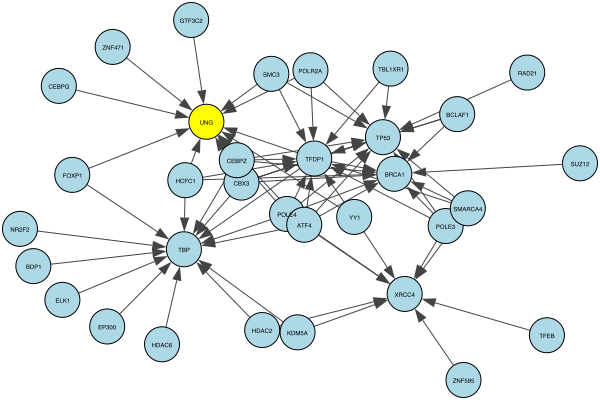

In [42]:
UNG_grn1 = filter_graph_by_targets(
    UNG_grn,'UNG',
    max_distance=1, 
    weight_thr=0.002
)

plot_graph(UNG_grn1,'kk',b1=600,b2=400,main_node='UNG')

IGRAPH DNW- 22 41 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 22
Number of edges in the graph 41
Is the graph directed: True
Maximum degree in the graph: 9
Node name with Maximum degree: ['ATF4']


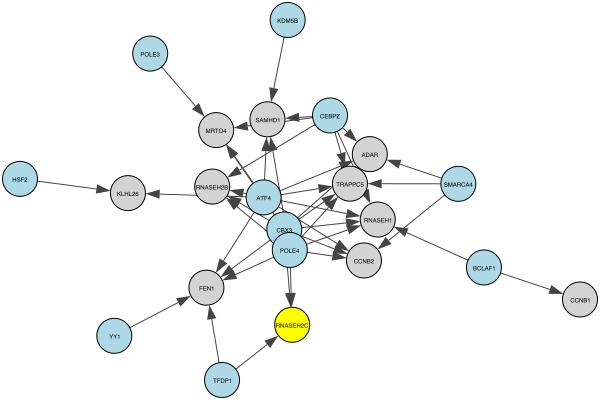

In [43]:
RNASEH2C_grn1 = filter_graph_by_targets(
    RNASEH2C_grn,'RNASEH2C',
    max_distance=2, 
    weight_thr=0.0031
)

plot_graph(RNASEH2C_grn1,'kk',b1=600,b2=400,main_node='RNASEH2C')

___

TFDP1

["Transcription factor Dp-1; Can stimulate E2F-dependent transcription. Binds DNA cooperatively with E2F family members through the E2 recognition site, 5'-TTTC[CG]CGC-3', found in the promoter region of a number of genes whose products are involved in cell cycle regulation or in DNA replication. The E2F1:DP complex appears to mediate both cell proliferation and apoptosis. Blocks adipocyte differentiation by repressing CEBPA binding to its target gene promoters; Belongs to the E2F/DP family"]


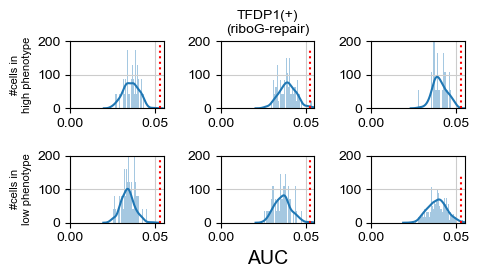

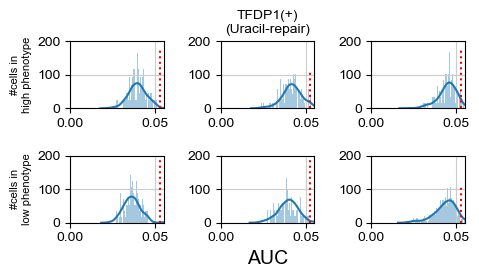

ATF4

["Cyclic AMP-dependent transcription factor ATF-4; Transcriptional activator. Binds the cAMP response element (CRE) (consensus: 5'-GTGACGT[AC][AG]-3'), a sequence present in many viral and cellular promoters. Cooperates with FOXO1 in osteoblasts to regulate glucose homeostasis through suppression of beta-cell production and decrease in insulin production (By similarity). It binds to a Tax-responsive enhancer element in the long terminal repeat of HTLV-I. Regulates the induction of DDIT3/CHOP and asparagine synthetase (ASNS) in response to endoplasmic reticulum (ER) stress. In concert wit [...] "]


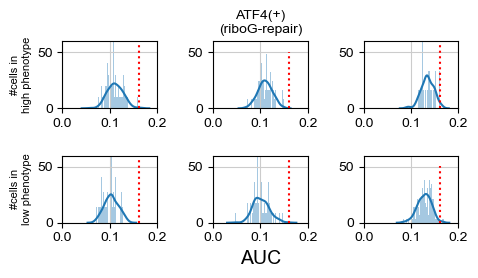

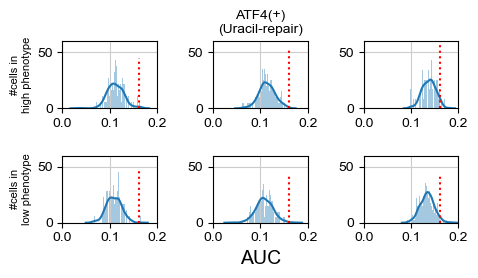

In [44]:
# 1. Sub-network with short distance from KO genes
## UNG
tf = 'TFDP1'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=200,xlim=[0,0.055])
## RNASEH2C
tf = 'ATF4'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=60,xlim=[0,0.2])

___
## 2. Top TFs targeting KO genes

In [45]:
def important_TF(graph,thr=0.01,adjacencies=adjacencies,plot=True,label='KO'):
    
    df = nodes2df(graph)[nodes2df(graph).name.isin(adjacencies.TF)]
    
    TF_df = adjacencies.loc[(
        (adjacencies.TF.isin(df.name) ) | 
        (adjacencies.target.isin(df.name) ) 
        ) & (adjacencies.importance >= thr)
        ,
        ['TF','importance']
    ]

    TF_df = TF_df.sort_values('importance').drop_duplicates('TF', keep='last')

    if plot:
        fig = TF_df.plot.bar(x="TF", y="importance",figsize=(18, 6))

        plt.title(f'TF\'s targeting {label} genes\n',fontsize=20)
        plt.grid(False)
        plt.ylabel('Importance')
        plt.show()
    
    return TF_df

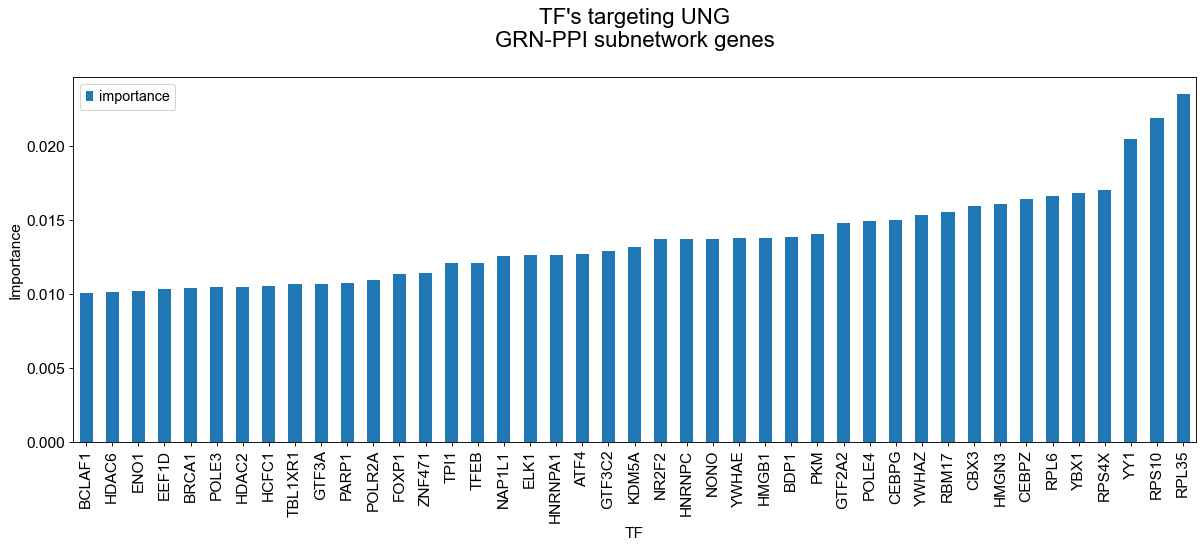

In [46]:
UNG_TF = important_TF(UNG_grn1, label='UNG\nGRN-PPI subnetwork') 

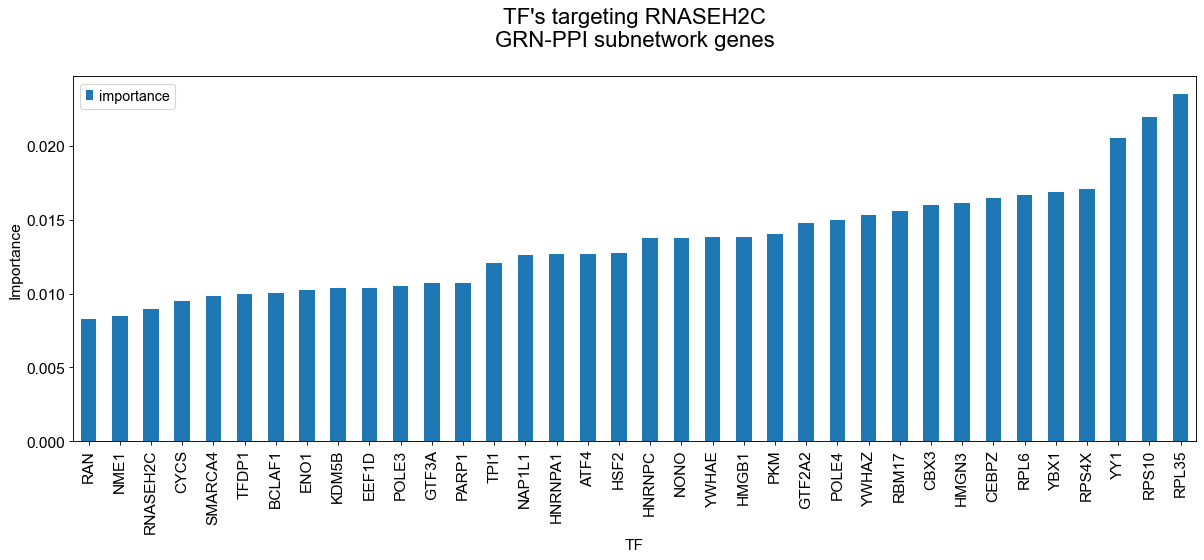

In [47]:
RNASEH2C_TF = important_TF(RNASEH2C_grn1,label='RNASEH2C\nGRN-PPI subnetwork',thr=0.008)

In [48]:
print ('UNG unique TFs')
UNG_tf1 = [i for i in set(important_TF(UNG_grn1, thr=0.011,plot=False).TF) if i not in set(RNASEH2C_TF.TF)]
print (UNG_tf1)

print ('\n')
print ('RNASEH2C unique TFs')
RNASEH2C_tf1=[i for i in set(important_TF(RNASEH2C_grn1, thr=0.01,plot=False).TF) if i not in set(UNG_TF.TF)]
print (RNASEH2C_tf1)

print ('\n')
print ('Shared TFs')
shared_tf = list(
    set(important_TF(UNG_grn1, thr=0.015,plot=False).TF) 
    and 
    set(important_TF(RNASEH2C_grn1, thr=0.015,plot=False).TF)
)
print (shared_tf)

UNG unique TFs
['CEBPG', 'GTF3C2', 'KDM5A', 'ZNF471', 'ELK1', 'FOXP1', 'TFEB', 'NR2F2', 'BDP1']


RNASEH2C unique TFs
['HSF2', 'KDM5B']


Shared TFs
['RPS4X', 'YY1', 'RPL6', 'RPL35', 'CEBPZ', 'YWHAZ', 'RPS10', 'HMGN3', 'CBX3', 'YBX1', 'RBM17']


___

In [49]:
UNG_grn2 = filter_graph_by_regulon(
    UNG_grn,
    regulons= [i for i in UNG_tf1 + shared_tf if i in UNG_grn.vs['name']],
    weight_thr=0.0035
)


RNASEH2C_grn2 = filter_graph_by_regulon(
    RNASEH2C_grn,
    regulons= [i for i in RNASEH2C_tf1 + shared_tf if i in RNASEH2C_grn.vs['name'] ],
    weight_thr=0.0015
)

IGRAPH DNW- 75 103 -- 
+ attr: color (v), name (v), weight (e) 

Number of vertices in the graph: 75
Number of edges in the graph 103
Is the graph directed: True
Maximum degree in the graph: 67
Node name with Maximum degree: ['CBX3']


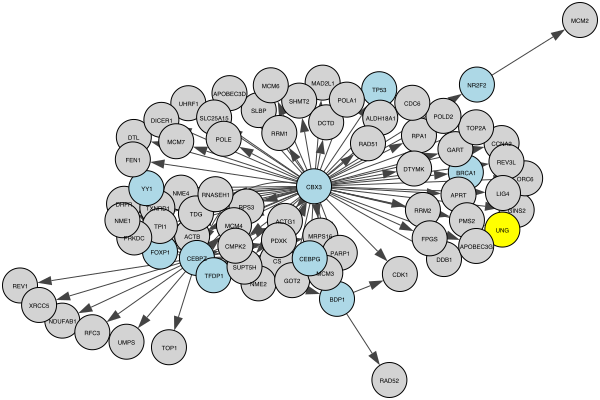

In [158]:
get_graph_features(UNG_grn2)
plot_graph(UNG_grn2,'auto',b1=600,b2=400,main_node='UNG')

IGRAPH DNW- 18 51 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 18
Number of edges in the graph 51
Is the graph directed: True
Maximum degree in the graph: 19
Node name with Maximum degree: ['CBX3', 'CEBPZ']


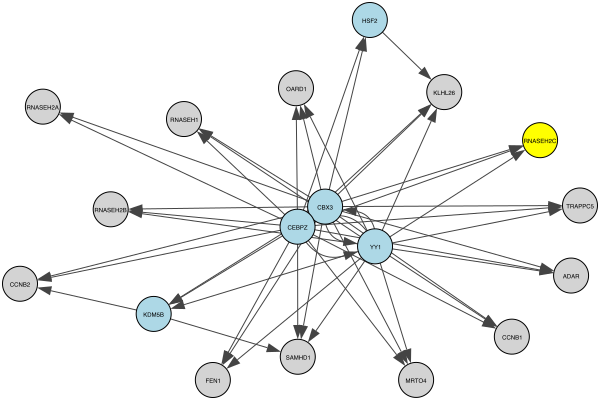

In [51]:
get_graph_features(RNASEH2C_grn2)
plot_graph(RNASEH2C_grn2,'auto',b1=600,b2=400,main_node='RNASEH2C')

___
<!-- > ### [**CBX3 regulates efficient RNA processing genome-wide**](http://www.genome.org/cgi/10.1101/gr.124818.111)
> - CBX5, CBX1, and CBX3 (HP1α, β, and γ, respectively) play an evolutionarily conserved role in the formation and maintenance of heterochromatin. In addition, CBX5, CBX1, and CBX3 may also participate in transcriptional regulation of genes. Recently, CBX3 binding to the bodies of a subset of genes has been observed in human and murine cells. However, the generality of this phenomenon and the role CBX3 may play in this context are unknown. Genome-wide localization analysis reveals CBX3 binding at genic regions, which strongly correlates with gene activity across multiple cell types. Depletion of CBX3 resulted in down-regulation of a subset of target genes. Loss of CBX3 binding leads to a more dramatic accumulation of unspliced nascent transcripts. In addition, we observed defective recruitment of splicing factors, including SNRNP70, to CBX3 target genes. Collectively, our data suggest a role for CBX3 in aiding in efficient cotranscriptional RNA processing.
> - Once thought of as static components of heterochromatin, heterochromatin protein 1 family members (HP1s—CBX5, CBX1, and CBX3) are now known to function in a myriad of cellular processes, including **DNA repair**, gene regulation, and telomere function.

> ### [**The Heterochromatin Protein 1 family**](https://doi.org/10.1186/gb-2006-7-7-228)
> - In humans, HP1α is encoded by the Chromobox homolog 5 (CBX5) gene located on chromosome 12q13.13. The genes for HP1β (CBX1) and HP1γ (**CBX3**) are located on chromosomes 17q21.32 and 7p15.2, respectively. 

> ### [**Heterochromatin protein 1: don’t judge the book by its cover!**](https://doi.org/10.1016/j.gde.2006.02.013)
> - The name heterochromatin protein 1 (HP1) suggests that this small nuclear factor plays a role in forming heterochromatic domains. It was noticed years ago, however, that the distribution of HP1 on polytene chromosomes was not restricted to chromocenters or telomeres. HP1 was also found, reproducibly, along the euchromatic arms. A possible function in euchromatic gene regulation was postulated. Now, a large body of data has blurred the definition of HP1 as a structural component of heterochromatin, revealing its two-faced nature. Not only do HP1 isoforms have specific binding sites in both heterochromatic and euchromatic domains but they might also participate in the repression and activation of transcription in both compartments.

 -->

CBX3

["Chromobox protein homolog 3; Seems to be involved in transcriptional silencing in heterochromatin-like complexes. Recognizes and binds histone H3 tails methylated at 'Lys-9', leading to epigenetic repression. May contribute to the association of the heterochromatin with the inner nuclear membrane through its interaction with lamin B receptor (LBR). Involved in the formation of functional kinetochore through interaction with MIS12 complex proteins. Contributes to the conversion of local chromatin to a heterochromatin-like repressive state through H3 'Lys-9' trimethylation, mediates the  [...] "]


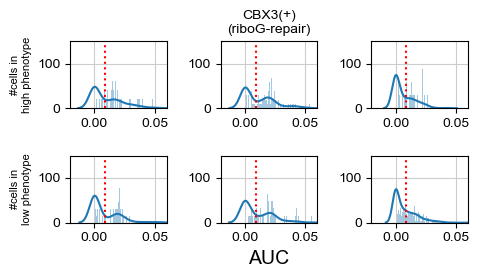

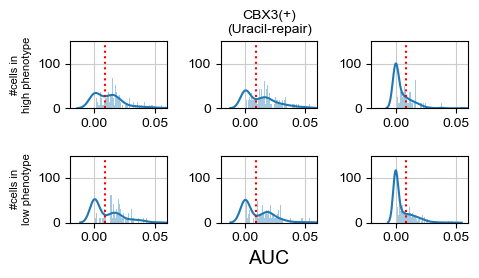

In [190]:
# 2. Top TFs targeting KO genes
# ## UNG & RNASEH2C
# tf = 'YY1'
# print(f'{start}{tf}{end}\n')
# print(list(stringdb.get_string_ids([tf]).annotation))
# for repair in ['riboG-repair','Uracil-repair']:
#     plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=500,xlim=[0.04,0.08])

tf = 'CBX3'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (
        adata,f'{tf}(+)',repair,ylim=150,xlim=[-0.02,0.06],
        save=f'network-analysis/{tf}-{repair}-regulon.pdf'
    )

# ## RNASEH2C only
# tf ='CEBPZ'
# print(f'{start}{tf}{end}\n')
# print(list(stringdb.get_string_ids([tf]).annotation))
# for repair in ['riboG-repair','Uracil-repair']:
#     plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=350,xlim=[0.02,0.055])

___
## 3. DNA Damage and Repair (DDR) related Transcription Factors

__UNG__

In [53]:
DDR_genes.intersection(TFs)

{'BRCA1', 'POLE3', 'POLE4', 'SMARCA4', 'TP53', 'XRCC4'}

In [54]:
UNG_grn3 = filter_graph_by_regulon(
    UNG_grn,
    regulons= [i for i in DDR_genes.intersection(TFs) if i in UNG_grn.vs['name'] and i ],
#     weight_thr=0.001
)

UNG_grn3=UNG_grn3.vs.select(
    name_in= 
    [i for i in DDR_core_pathways['Base Excision Repair (BER)'] if i not in TFs]+
    run_bfs(UNG_grn3,'UNG',distance=1) #+ run_bfs(UNG_grn3,'UNG',distance=2)
).subgraph()

IGRAPH DNW- 14 78 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 14
Number of edges in the graph 78
Is the graph directed: True
Maximum degree in the graph: 18
Node name with Maximum degree: ['POLE4', 'SMARCA4', 'POLE3', 'BRCA1', 'TP53', 'XRCC4']


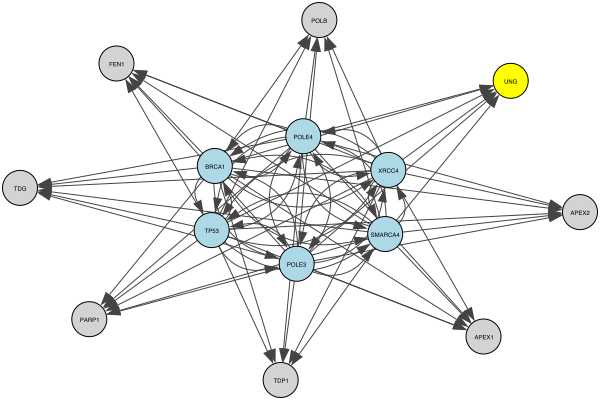

In [55]:
get_graph_features(UNG_grn3)
plot_graph(UNG_grn3,'kk',b1=600,b2=400,main_node='UNG')

__RNASEH2C__

In [56]:
RNASEH2C_grn3 = filter_graph_by_regulon(
    RNASEH2C_grn,
    regulons= [i for i in DDR_genes.intersection(TFs) if i in RNASEH2C_grn.vs['name'] ],
#     weight_thr=0.001
)


RNASEH2C_grn3=RNASEH2C_grn.vs.select(
    name_in=
    ['RNASEH2C']+
    [i for i in DDR_core_pathways['Base Excision Repair (BER)'] if i not in TFs]+
    run_bfs(RNASEH2C_grn3,'RNASEH2C',distance=1) + run_bfs(RNASEH2C_grn3,'RNASEH2C',distance=2)
).subgraph()

IGRAPH DNW- 19 78 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 19
Number of edges in the graph 78
Is the graph directed: True
Maximum degree in the graph: 13
Node name with Maximum degree: ['POLE4', 'POLE3', 'SMARCA4', 'BRCA1', 'TP53', 'XRCC4']


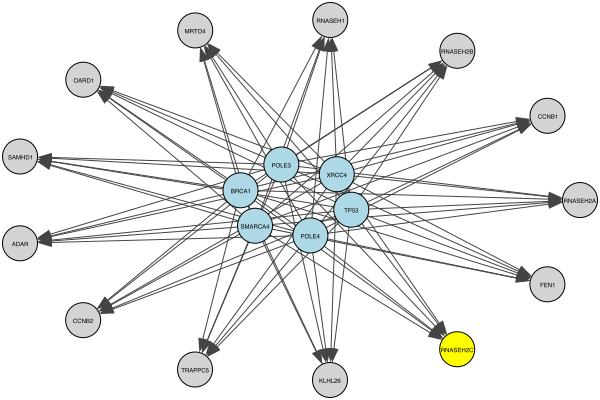

In [57]:
get_graph_features(RNASEH2C_grn3)
plot_graph(RNASEH2C_grn3,'kk',b1=600,b2=400,main_node='RNASEH2C')

XRCC4

['DNA repair protein XRCC4; Involved in DNA non-homologous end joining (NHEJ) required for double-strand break repair and V(D)J recombination. Binds to DNA and to DNA ligase IV (LIG4). The LIG4-XRCC4 complex is responsible for the NHEJ ligation step, and XRCC4 enhances the joining activity of LIG4. Binding of the LIG4-XRCC4 complex to DNA ends is dependent on the assembly of the DNA-dependent protein kinase complex DNA-PK to these DNA ends']


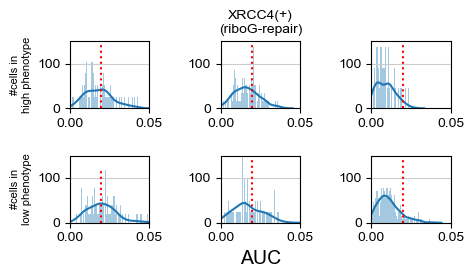

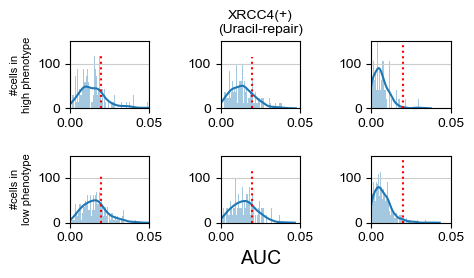

TP53

['Cellular tumor antigen p53; Acts as a tumor suppressor in many tumor types; induces growth arrest or apoptosis depending on the physiological circumstances and cell type. Involved in cell cycle regulation as a trans-activator that acts to negatively regulate cell division by controlling a set of genes required for this process. One of the activated genes is an inhibitor of cyclin-dependent kinases. Apoptosis induction seems to be mediated either by stimulation of BAX and FAS antigen expression, or by repression of Bcl-2 expression. In cooperation with mitochondrial PPIF is involved in  [...] ']


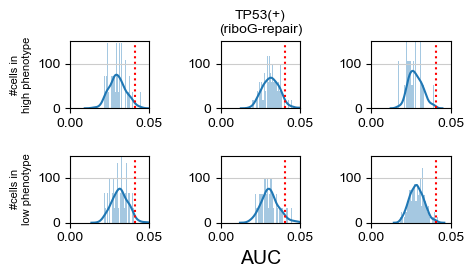

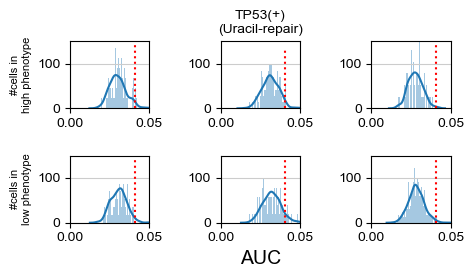

In [58]:
# 3. DNA Damage and Repair (DDR) related Transcription Factors
## UNG & RNASEH2C
tf = 'XRCC4'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=150,xlim=[0,0.05])


# tf = 'BRCA1'
# print(f'{start}{tf}{end}\n')
# print(list(stringdb.get_string_ids([tf]).annotation))
# for repair in ['riboG-repair','Uracil-repair']:
#     plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=250,xlim=[0,0.05])
    
# tf = 'POLE3'
# print(f'{start}{tf}{end}\n')
# print(list(stringdb.get_string_ids([tf]).annotation))
# for repair in ['riboG-repair','Uracil-repair']:
#     plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=250,xlim=[0,0.08])
# tf = 'POLE4'
# print(f'{start}{tf}{end}\n')
# print(list(stringdb.get_string_ids([tf]).annotation))
# for repair in ['riboG-repair','Uracil-repair']:
#     plot_binarization_over_time (adata,f'{tf}(+)',repair)#,ylim=150,xlim=[0,0.05])
# tf = 'SMARCA4'
# print(f'{start}{tf}{end}\n')
# print(list(stringdb.get_string_ids([tf]).annotation))
# for repair in ['riboG-repair','Uracil-repair']:
#     plot_binarization_over_time (adata,f'{tf}(+)',repair)#,ylim=150,xlim=[0,0.05])
tf = 'TP53'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (adata,f'{tf}(+)',repair,ylim=150,xlim=[0,0.05])


___

## 4. Find TFs with dynamic regulon activity 

In [65]:
bdata = ann.AnnData(X=bin_mtx, obs=adata.obs)

In [66]:
bdata_rG = bdata[bdata.obs['riboG-repair'] != 'none']
bdata_dU = bdata[bdata.obs['Uracil-repair'] != 'none']

In [67]:
# bdata_rG.X[bdata_rG.obs['riboG-repair'] == 'high'].sum(axis=0),

In [188]:
sorted([
    (
        bdata_rG.var.index[i],
        (x_h,x_l),(y_h,y_l),(z_h,z_l),
        bdata_rG.X.shape[0] -x_h-x_l-y_h-y_l-z_h-z_l
    ) for i,(x_h,x_l,y_h,y_l,z_h,z_l) in enumerate(zip (
        bdata_rG.X[(bdata_rG.obs['riboG-repair'] == 'high') & (bdata_rG.obs['time'] == 15)].sum(axis=0),
        bdata_rG.X[(bdata_rG.obs['riboG-repair'] == 'low') & (bdata_rG.obs['time'] == 15)].sum(axis=0),
        bdata_rG.X[(bdata_rG.obs['riboG-repair'] == 'high') & (bdata_rG.obs['time'] == 30)].sum(axis=0),
        bdata_rG.X[(bdata_rG.obs['riboG-repair'] == 'low') & (bdata_rG.obs['time'] == 30)].sum(axis=0),
        bdata_rG.X[(bdata_rG.obs['riboG-repair'] == 'high') & (bdata_rG.obs['time'] == 60)].sum(axis=0),
        bdata_rG.X[(bdata_rG.obs['riboG-repair'] == 'low') & (bdata_rG.obs['time'] == 60)].sum(axis=0)
        #         bdata_rG.X[bdata_rG.obs['riboG-repair'] == 'low'].sum(axis=0)
    )) 
    if 
    (z_h>y_h and z_h>x_h and x_h>0 and y_h>0 and z_h>10) 
#     or 
#     (z_h>z_l and x_h*x_l*y_h*y_l*z_h*z_l>0) 
    
],key=lambda x: x[4])#[0:5]

[('DDIT3(+)', (81.0, 71.0), (114.0, 67.0), (130.0, 423.0), 845.0)]

In [186]:
sorted([
    (
        bdata_dU.var.index[i],
        (x_h,x_l),(y_h,y_l),(z_h,z_l),
        bdata_dU.X.shape[0] -x_h-x_l-y_h-y_l-z_h-z_l
    ) for i,(x_h,x_l,y_h,y_l,z_h,z_l) in enumerate(zip (
        bdata_dU.X[(bdata_dU.obs['Uracil-repair'] == 'high') & (bdata_dU.obs['time'] == 15)].sum(axis=0),
        bdata_dU.X[(bdata_dU.obs['Uracil-repair'] == 'low') & (bdata_dU.obs['time'] == 15)].sum(axis=0),
        bdata_dU.X[(bdata_dU.obs['Uracil-repair'] == 'high') & (bdata_dU.obs['time'] == 30)].sum(axis=0),
        bdata_dU.X[(bdata_dU.obs['Uracil-repair'] == 'low') & (bdata_dU.obs['time'] == 30)].sum(axis=0),
        bdata_dU.X[(bdata_dU.obs['Uracil-repair'] == 'high') & (bdata_dU.obs['time'] == 60)].sum(axis=0),
        bdata_dU.X[(bdata_dU.obs['Uracil-repair'] == 'low') & (bdata_dU.obs['time'] == 60)].sum(axis=0)
    )) 
    if 
    (z_h>y_h and z_h>x_h and x_h>0 and y_h>0 and z_h>10) 
#     or 
#     (z_h<y_h and z_h<x_h and x_h>10 and y_h>10 and z_h>10) 
    
],key=lambda x: x[4])#[0:5]

[('SIX2(+)', (192.0, 194.0), (259.0, 155.0), (269.0, 882.0), 647.0),
 ('DDIT3(+)', (125.0, 154.0), (169.0, 104.0), (210.0, 606.0), 1230.0)]

DDIT3

['DNA damage-inducible transcript 3 protein; Multifunctional transcription factor in ER stress response. Plays an essential role in the response to a wide variety of cell stresses and induces cell cycle arrest and apoptosis in response to ER stress. Plays a dual role both as an inhibitor of CCAAT/enhancer-binding protein (C/EBP) function and as an activator of other genes. Acts as a dominant-negative regulator of C/EBP-induced transcription: dimerizes with members of the C/EBP family, impairs their association with C/EBP binding sites in the promoter regions, and inhibits the expression  [...] ']


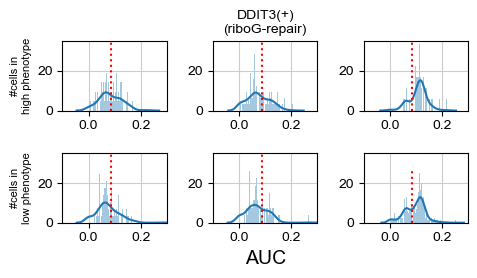

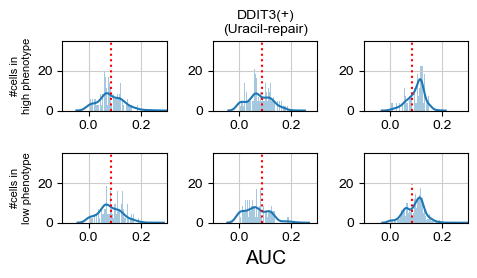

In [144]:
# 5. 
tf = 'DDIT3'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (
        adata,f'{tf}(+)',repair,ylim=35,xlim=[-0.1,0.3], 
        save=f'network-analysis/{tf}-{repair}-regulon.pdf'
    )

SIX2

['Homeobox protein SIX2; Transcription factor that plays an important role in the development of several organs, including kidney, skull and stomach. During kidney development, maintains cap mesenchyme multipotent nephron progenitor cells in an undifferentiated state by opposing the inductive signals emanating from the ureteric bud and cooperates with WNT9B to promote renewing progenitor cells proliferation. Acts through its interaction with TCF7L2 and OSR1 in a canonical Wnt signaling independent manner preventing transcription of differentiation genes in cap mesenchyme such as WNT4. Al [...] ']


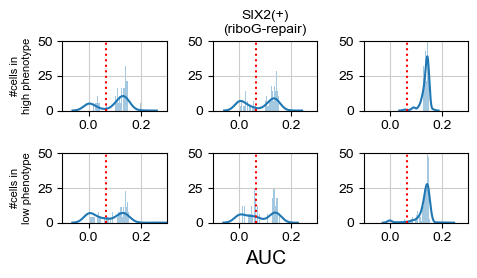

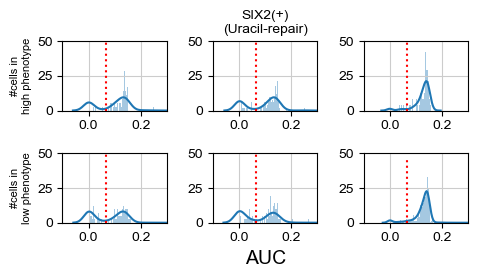

In [145]:
# 5. 
tf = 'SIX2'
print(f'{start}{tf}{end}\n')
print(list(stringdb.get_string_ids([tf]).annotation))
for repair in ['riboG-repair','Uracil-repair']:
    plot_binarization_over_time (
        adata,f'{tf}(+)',repair,ylim=50,xlim=[-0.1,0.3],
        save=f'network-analysis/{tf}-{repair}-regulon.pdf'
    )

___

In [72]:
UNG_grn4 = filter_graph_by_regulon(
    UNG_grn,
    regulons= ['SIX2','DDIT3'],
    weight_thr=0.0011
)

UNG_grn4=UNG_grn.vs.select(
    name_in=['UNG','SIX2','DDIT3']+
    run_bfs(UNG_grn4,'UNG',distance=1) + run_bfs(UNG_grn4,'UNG',distance=2)
).subgraph()

IGRAPH DNW- 29 76 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 29
Number of edges in the graph 76
Is the graph directed: True
Maximum degree in the graph: 27
Node name with Maximum degree: ['DDIT3', 'TBP']


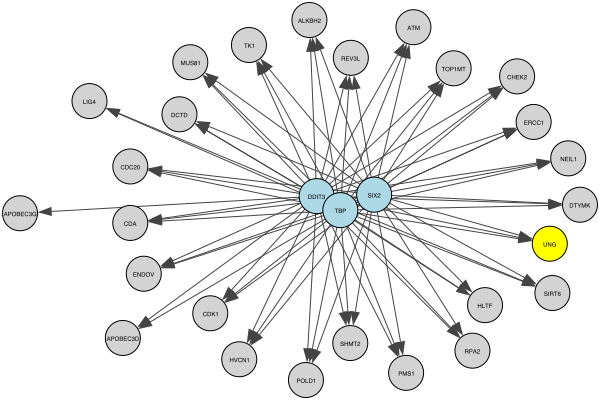

In [73]:
get_graph_features(UNG_grn4)
plot_graph(UNG_grn4,'kk',b1=600,b2=400,main_node='UNG')

In [75]:
RNASEH2C_grn4 = filter_graph_by_regulon(
    RNASEH2C_grn,
    regulons= ['SIX2','DDIT3'],
#     weight_thr=0.001
)

RNASEH2C_grn4=RNASEH2C_grn.vs.select(
    name_in=['UNG','RNASEH2C','SIX2','DDIT3']+
    run_bfs(RNASEH2C_grn4,'DDIT3',distance=1) + run_bfs(RNASEH2C_grn4,'SIX2',distance=2)
).subgraph()

IGRAPH DNW- 15 25 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 15
Number of edges in the graph 25
Is the graph directed: True
Maximum degree in the graph: 13
Node name with Maximum degree: ['DDIT3']


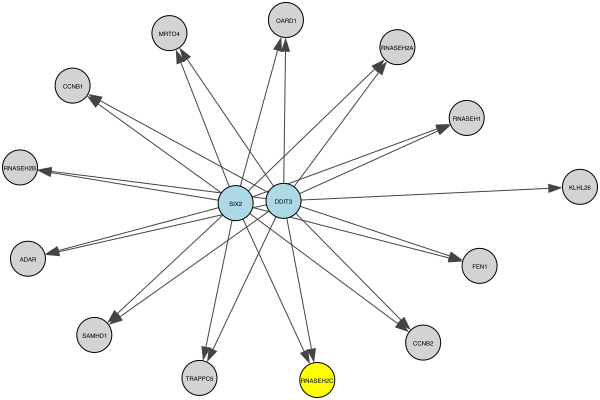

In [76]:
get_graph_features(RNASEH2C_grn4)
plot_graph(RNASEH2C_grn4,'kk',b1=600,b2=400,main_node='RNASEH2C')

# Downstream tasks:


## mRNA expression and regulon activity (AUCell result) t-SNE visualization
1. Normalize mRNA counts 
1. Remove batch effect using the time variable (same as the batch)
1. Compute and visualize t-SNE plots 

In [79]:
%%time 
from utils import cluster

mRNA_expression = sc.read_h5ad('preprocessing/mix.h5ad.gz')
mRNA_expression.obs.time = mRNA_expression.obs.time.astype('str')

TF_activity = bdata.copy()
TF_activity.obs.time = TF_activity.obs.time.astype('str')

CPU times: user 847 ms, sys: 143 ms, total: 990 ms
Wall time: 1.05 s


In [113]:
# Uracil-repair
mRNA_dU = mRNA_expression[mRNA_expression.obs['Uracil-repair'] != 'none',].copy()
sc.pp.normalize_total(mRNA_dU)
sc.pp.combat(mRNA_dU, key='time', covariates=['Uracil-repair'])
sc.tl.tsne(mRNA_dU)

TF_act_dU = TF_activity[TF_activity.obs['Uracil-repair'] != 'none',].copy()
sc.pp.combat(TF_act_dU, key='time', covariates=['Uracil-repair'])
sc.tl.tsne(TF_act_dU)

# riboG-repair
mRNA_rG = mRNA_expression[mRNA_expression.obs['riboG-repair']  != 'none',].copy()
sc.pp.normalize_total(mRNA_rG)
sc.pp.combat(mRNA_rG, key='time', covariates=['riboG-repair'])
sc.tl.tsne(mRNA_rG)

TF_act_rG = TF_activity[TF_activity.obs['riboG-repair']  != 'none',].copy()
sc.pp.combat(TF_act_rG, key='time', covariates=['riboG-repair'])
sc.tl.tsne(TF_act_rG)

... storing 'time' as categorical


Found 14 genes with zero variance.


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'time' as categorical
         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'time' as categorical


Found 140 genes with zero variance.


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'time' as categorical
         Falling back to preprocessing with `sc.pp.pca` and default params.


Found 3 genes with zero variance.


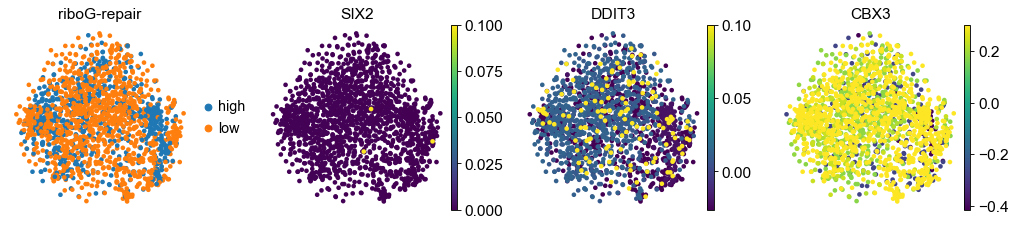

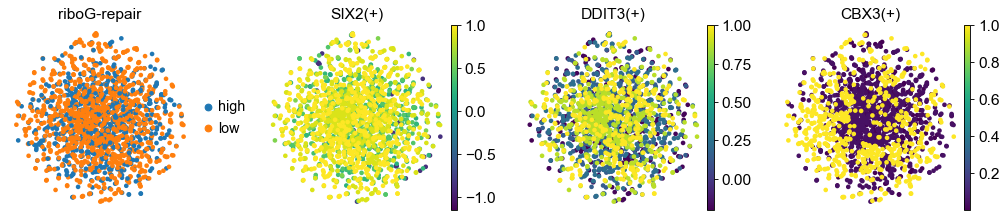

In [199]:
sc.pl.tsne(
    mRNA_rG,color=['riboG-repair','SIX2','DDIT3', 'CBX3'],
    vmax=[None,0.1,0.1,0.3],
    save='riboG-repair-mRNA-expression.pdf'
)

sc.pl.tsne(
    TF_act_rG, color=['riboG-repair','SIX2(+)','DDIT3(+)','CBX3(+)'],
    vmax=[None,1,1,1],
    save='riboG-repair-TF-activity.pdf'
)

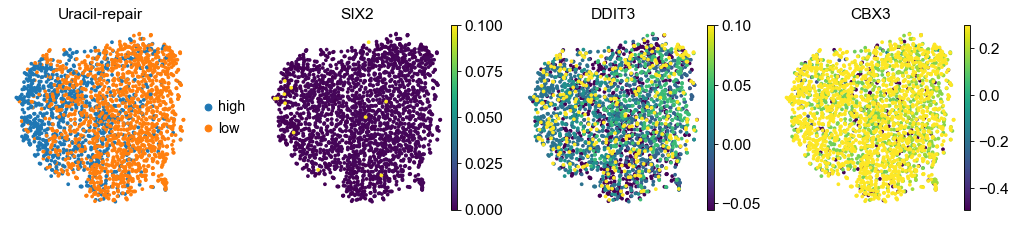

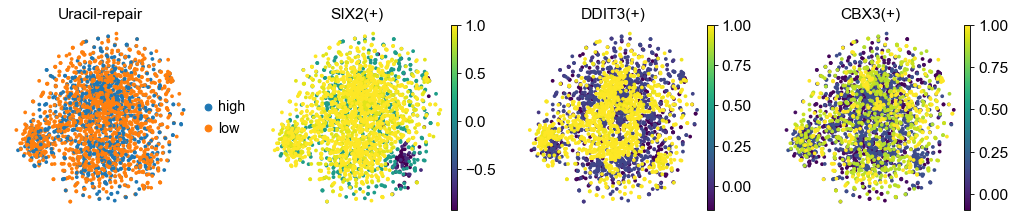

In [200]:
sc.pl.tsne(
    mRNA_dU,color=['Uracil-repair','SIX2','DDIT3', 'CBX3'],
    vmax=[None,0.1,0.1,0.3],
    save='Uracil-repair-mRNA-expression.pdf'
)

sc.pl.tsne(
    TF_act_dU, color=['Uracil-repair','SIX2(+)','DDIT3(+)','CBX3(+)'],
    vmax=[None,1,1,1],
    save='Uracil-repair-TF-activity.pdf'
)

In [201]:
!for f in figures/*; do o=${f/figures\/tsne/network-analysis\/tsne-}; mv -v $f $o; done 

figures/tsneUracil-repair-TF-activity.pdf -> network-analysis/tsne-Uracil-repair-TF-activity.pdf
figures/tsneUracil-repair-mRNA-expression.pdf -> network-analysis/tsne-Uracil-repair-mRNA-expression.pdf
figures/tsneriboG-repair-TF-activity.pdf -> network-analysis/tsne-riboG-repair-TF-activity.pdf
figures/tsneriboG-repair-mRNA-expression.pdf -> network-analysis/tsne-riboG-repair-mRNA-expression.pdf


## Explore PPI of altered TFs

In [202]:
string_ids = stringdb.get_string_ids(['SIX2','DDIT3','CBX3'])
interaction_partners_df = stringdb.get_interaction_partners(string_ids.queryItem).sort_values('score',ascending=False)

In [203]:
SIX2 = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'SIX2', ].reset_index(drop=True)
SIX2_net = stringdb.get_network(SIX2.preferredName_B.to_list() + ['SIX2'])
SIX2_ppi = SIX2.loc[SIX2.score >= 0.75,'preferredName_B'].to_list()
SIX2_ppi

['EYA1',
 'EYA3',
 'EYA4',
 'EYA2',
 'PAX2',
 'GDNF',
 'TLX1',
 'FOXD1',
 'DACH1',
 'SALL1']

In [204]:
DDIT3 = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'DDIT3', ].reset_index(drop=True)
DDIT3_net = stringdb.get_network(DDIT3.preferredName_B.to_list() + ['DDIT3'])
DDIT3_ppi = DDIT3.loc[DDIT3.score > 0.9,'preferredName_B'].to_list()
DDIT3_ppi

['ATF4',
 'ATF6',
 'XBP1',
 'ATF3',
 'MAPK14',
 'HSPA5',
 'CEBPB',
 'MAPK11',
 'BCL2L11',
 'NFYA',
 'NFYC',
 'NFYB']

In [221]:
CBX3 = interaction_partners_df.loc[interaction_partners_df.preferredName_A == 'CBX3', ].reset_index(drop=True)
CBX3_net = stringdb.get_network(CBX3.preferredName_B.to_list() + ['CBX3'])
CBX3_ppi = CBX3.loc[CBX3.score > 0.92,'preferredName_B'].to_list()
CBX3_ppi

['H3F3A',
 'HIST1H1E',
 'HIST2H3PS2',
 'EHMT2',
 'HIST1H3D',
 'L3MBTL2',
 'HIST2H3D',
 'HIST2H3A',
 'HIST1H3A',
 'HIST2H3C',
 'H3F3B',
 'HIST1H3E',
 'HIST3H3',
 'CHD4',
 'EHMT1',
 'H3F3C',
 'HIST1H3C',
 'H2AFZ',
 'PCGF6',
 'HDAC2',
 'HDAC1',
 'RING1',
 'E2F6',
 'HIST1H3F',
 'HIST1H3B',
 'HIST1H3J',
 'HIST1H3I',
 'HIST1H3G',
 'HIST1H3H',
 'H2AFV',
 'HIST2H2AC',
 'H2AFB1',
 'RNF2',
 'H2AFX',
 'CHD3',
 'RBBP7',
 'RBBP4',
 'YAF2',
 'HIST1H2AD',
 'H2AFJ',
 'HIST2H2BE',
 'TFDP1',
 'HIST1H2BJ',
 'HIST1H2AJ',
 'HIST1H2AC',
 'HIST1H2BA',
 'CDC7']

__UNG__

In [229]:
UNG_grn5 = filter_graph_by_regulon(
    UNG_grn,
    regulons= [gene for gene in SIX2_ppi + DDIT3_ppi + CBX3_ppi if gene in TFs],
)

UNG_grn5=UNG_grn.vs.select(
    name_in=['UNG','SIX2','DDIT3','CBX3']+[gene for gene in SIX2_ppi + DDIT3_ppi + CBX3_ppi + UNG_ppi if gene in TFs] +
    run_bfs(UNG_grn5,'UNG',distance=1) #+ run_bfs(UNG_grn5,'UNG',distance=2)
).subgraph()

IGRAPH DNW- 20 109 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 20
Number of edges in the graph 109
Is the graph directed: True
Maximum degree in the graph: 23
Node name with Maximum degree: ['TFDP1', 'BRCA1', 'TP53', 'XRCC4', 'TBP']


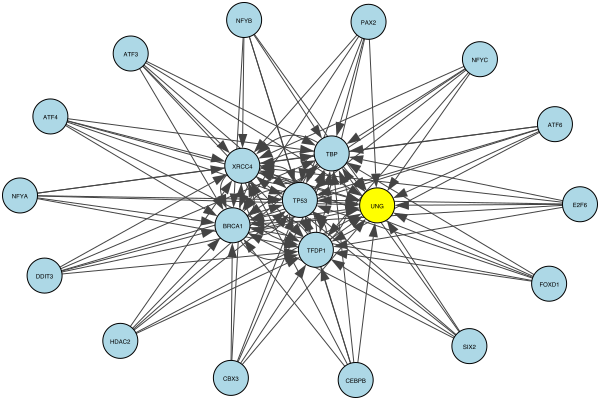

In [230]:
get_graph_features(UNG_grn5)
plot_graph(UNG_grn5,'kk',b1=600,b2=400,main_node='UNG')

__RNASEH2C__

In [225]:
RNASEH2C_grn5 = filter_graph_by_regulon(
    RNASEH2C_grn,
    regulons= [gene for gene in SIX2_ppi + DDIT3_ppi + CBX3_ppi if gene in TFs],
#     weight_thr=0.002
)

RNASEH2C_grn5=RNASEH2C_grn.vs.select(
    name_in=['RNASEH2C','SIX2','DDIT3','CBX3']+[gene for gene in SIX2_ppi + DDIT3_ppi + CBX3_ppi + RNASEH2C_ppi if gene in TFs] +
    run_bfs(RNASEH2C_grn5,'RNASEH2C',distance=1) + run_bfs(RNASEH2C_grn5,'RNASEH2C',distance=2)
).subgraph()

IGRAPH DNW- 28 194 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 28
Number of edges in the graph 194
Is the graph directed: True
Maximum degree in the graph: 15
Node name with Maximum degree: ['TRAPPC5', 'RNASEH1', 'FEN1', 'CCNB2', 'RNASEH2C', 'ADAR', 'SAMHD1', 'RNASEH2B', 'MRTO4', 'CCNB1', 'RNASEH2A', 'OARD1']


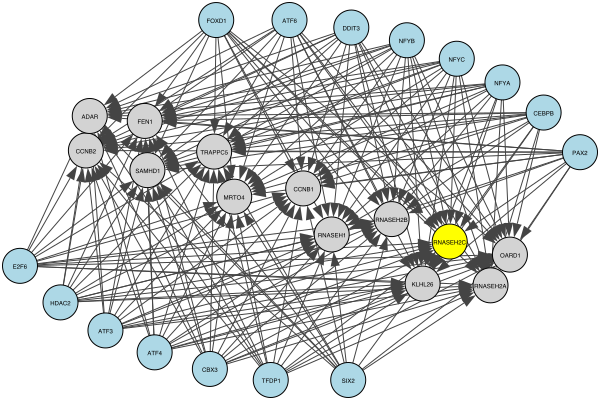

In [226]:
get_graph_features(RNASEH2C_grn5)
plot_graph(RNASEH2C_grn5,'kk',b1=600,b2=400,main_node='RNASEH2C')

## Differentially Expressed TFs and targets

__Load DESeq2 results__

In [236]:
deseq = dict([[os.path.basename(f).replace('.txt',''),pd.read_csv(f,sep='\t').rename(columns={'Unnamed: 0': 'genes'}).set_index('genes')] for f in glob('deseq/delta_*.txt')])

In [237]:
import upsetplot as us

def run_upset(fc_thr, pv_thr,draw=False):

    contents_dU = {
        '15\' l': deseq['delta_dU_15'].index[
            (deseq['delta_dU_15'].log2FoldChange < -fc_thr) & (deseq['delta_dU_15'].pvalue < pv_thr)
        ].tolist(),
        '15\' h': deseq['delta_dU_15'].index[
            (deseq['delta_dU_15'].log2FoldChange > fc_thr ) & (deseq['delta_dU_15'].pvalue < pv_thr)
        ].tolist(),
        '30\' l': deseq['delta_dU_30'].index[
            (deseq['delta_dU_30'].log2FoldChange < -fc_thr) & (deseq['delta_dU_30'].pvalue < pv_thr)
        ].tolist(),
        '30\' h': deseq['delta_dU_30'].index[
            (deseq['delta_dU_30'].log2FoldChange > fc_thr ) & (deseq['delta_dU_30'].pvalue < pv_thr)
        ].tolist(),
        '60\' l': deseq['delta_dU_60'].index[
            (deseq['delta_dU_60'].log2FoldChange < -fc_thr) & (deseq['delta_dU_60'].pvalue < pv_thr)
        ].tolist(),
        '60\' h': deseq['delta_dU_60'].index[
            (deseq['delta_dU_60'].log2FoldChange > fc_thr ) & (deseq['delta_dU_60'].pvalue < pv_thr)
        ].tolist()
    }

    contents_rG = {
        '15\' l': deseq['delta_rG_15'].index[
            (deseq['delta_rG_15'].log2FoldChange < -fc_thr) & (deseq['delta_rG_15'].pvalue < pv_thr)
        ].tolist(),
        '15\' h': deseq['delta_rG_15'].index[
            (deseq['delta_rG_15'].log2FoldChange > fc_thr ) & (deseq['delta_rG_15'].pvalue < pv_thr)
        ].tolist(),
        '30\' l': deseq['delta_rG_30'].index[
            (deseq['delta_rG_30'].log2FoldChange < -fc_thr) & (deseq['delta_rG_30'].pvalue < pv_thr)
        ].tolist(),
        '30\' h': deseq['delta_rG_30'].index[
            (deseq['delta_rG_30'].log2FoldChange > fc_thr ) & (deseq['delta_rG_30'].pvalue < pv_thr)
        ].tolist(),
        '60\' l': deseq['delta_rG_60'].index[
            (deseq['delta_rG_60'].log2FoldChange < -fc_thr) & (deseq['delta_rG_60'].pvalue < pv_thr)
        ].tolist(),
        '60\' h': deseq['delta_rG_60'].index[
            (deseq['delta_rG_60'].log2FoldChange > fc_thr ) & (deseq['delta_rG_60'].pvalue < pv_thr)
        ].tolist(),

    }
    if draw:
        fig1 = plt.figure()
        upset1 = us.UpSet(us.from_contents(contents_dU),orientation='horizontal',
                          sort_by='cardinality',
                          min_degree=2,
                          show_counts=True)
        upset1.plot(fig=fig1)

        plt.title('delta dU\n',fontsize=20)

        fig2 = plt.figure()
        upset2 = us.UpSet(us.from_contents(contents_rG),orientation='horizontal',
                          sort_by='cardinality',
                          min_degree=2,
                          show_counts=True)
        upset2.plot(fig=fig2)

        plt.title('delta rG\n',fontsize=20)

        plt.show()

    return contents_rG, contents_dU

In [251]:
contents_rG, contents_dU = run_upset(1,0.01)

## Literature search

- ### _DDIT3_
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=DDIT3
    - https://www.omim.org/entry/126337

- ### _SIX2_
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=SIX2
    - https://www.omim.org/entry/604994

- ### _CBX3_
    - https://www.genecards.org/cgi-bin/carddisp.pl?gene=CBX3


- ### _NFE2L2_

    [A genetic basis for the variation in the vulnerability of cancer to DNA damage](https://www.nature.com/articles/ncomms11428)

> __NFE2L2 pathway signatures__

> For the gene transcription signature of pathway NFE2L2 (or NRF2), we extracted the expression values from the CCLE dataset. For each gene, we normalized expression values to standard deviations from the median across cell lines. We computed the average normalized expression of the signature genes within each cell line in which data was available. Across the cell lines, we normalized the gene signature scores to standard deviations from the median across CCLE, and a ‘summary score’ for each pathway was computed as the average of the individual normalized signature scores70.

___
Further analysis!
<!-- ## Task: Cell cycle analysis! -->